In [9]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import numpy as np
import networkx as nx
from tqdm import tqdm_notebook as tqdm
from pysal.inequality.gini import Gini

from method.learned_cn_method import CNModule, LCIModule
from data import load_network
from util import Params, prepare_sns
from data import load_diseases, load_network
from go import GOParser
from scipy.misc import comb
import pickle

prepare_sns(sns, {})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
diseases_dict = load_diseases("../../data/associations/disgenet-associations.csv")
m = len(diseases_dict)
print("Loaded {} diseases.".format(m))

Loaded 2297 diseases.


In [11]:
ppi_networkx, ppi_network_adj, protein_to_node = load_network("../../data/networks/bio-pathways-network.txt")
n = ppi_network_adj.shape[0]
node_to_protein = {node: protein for protein, node in protein_to_node.items()}

In [12]:
n

21557

In [8]:
m = len(diseases_dict.values())
diseases = np.zeros((m, n), dtype=int)
index_to_disease = []
for i, disease in enumerate(diseases_dict.values()):
    disease_nodes = disease.to_node_array(protein_to_node)
    diseases[i, disease_nodes] = 1
    index_to_disease.append(disease)

## Common Interactions

Question: What fraction of common interactions go through node i?
Question: What fraction of diseases 

In [251]:
def compute_common_interactors(diseases_dict, adj, null=False): 
    ci_pairs = [set() for i in range(n)]
    ci_diseases = [set() for i in range(n)]
    for disease in tqdm(diseases_dict.values()):
        proteins = disease.to_node_array(protein_to_node)
        if null:
            proteins = np.random.choice(adj.shape[0], len(proteins), replace=False)

        for a, protein_a in enumerate(proteins):
            for b, protein_b in enumerate(proteins):
                if a < b:
                    break 
                neighbors_a = adj[protein_a, :]
                neighbors_b = adj[protein_b, :]
                cis = np.where(np.multiply(neighbors_a, neighbors_b) == 1)[0]
                for ci in cis:
                    ci_pairs[ci].add((protein_a, protein_b))
                    ci_diseases[ci].add(disease.id)
    return ci_pairs, ci_diseases

In [61]:
ci_pairs, ci_diseases = compute_common_interactors(diseases_dict, ppi_network_adj)

In [111]:
all_ci_pairs = set.union(*ci_pairs)

In [198]:
ci_n_pairs = np.array(map(len, ci_pairs))

In [117]:
# How many pairs of proteins are there that share a common interactor? 
print("{} proteins").format(len(all_ci_pairs))

857448 proteins


Text(0,0.5,'# of common interactors [log]')

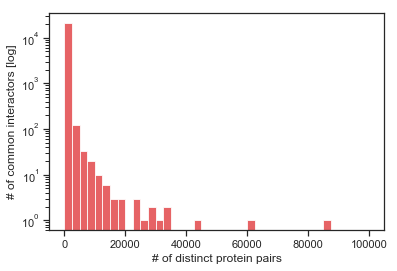

In [121]:
plt.hist(ci_n_pairs, 40, range=(0, 100000), alpha=0.8)
plt.yscale('log')
plt.xlabel('# of distinct protein pairs')
plt.ylabel('# of common interactors [log]')

In [56]:
# What is the GINI coefficient of 
Gini(n_pairs).g

0.9337597899800635

In [133]:
# How many protein pairs do common interactors have on average? 
print("{} protein pairs on average".format(np.sum(ci_n_pairs) / np.count_nonzero(ci_n_pairs)))

233 protein pairs on average


In [135]:
# Which proteins are common interactors for the most distinct pairs?
node_to_protein = {node: protein for protein, node in protein_to_node.items()}
[node_to_protein[node] for node in np.argsort(-1 * ci_n_pairs)][:10]

[4914, 351, 1994, 2885, 7157, 1956, 7316, 3320, 1017, 8452]

### Associated Diseases
For each protein i, we compute a) how many diseases i is directly associated with and b) For how many diseases does there exist a pair of associated proteins that share protein i as a common interactor? 

In [114]:
# How many diseases is protein i directly associated with
protein_n_diseases = np.sum(diseases, axis=0)
# For how many diseases does there exist a pair of associated proteins that share
# protein i as a common interactor? 
ci_n_diseases = np.array(map(len, ci_diseases))

Text(0,0.5,'# of proteins')

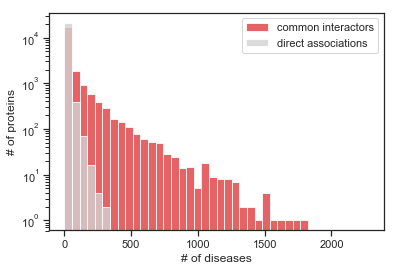

In [124]:
plt.hist(ci_n_diseases, 40, range=(0, 2279), alpha=0.8, label="common interactors")
plt.hist(protein_n_diseases, 40, range=(0, 2279), alpha=0.8, color='#D3D3D3', label="direct associations")
plt.yscale('log')
plt.legend()
plt.xlabel('# of diseases')
plt.ylabel('# of proteins')


In [158]:
# Which proteins are common interactors for the most diseases? 
node_to_protein = {node: protein for protein, node in protein_to_node.items()}
ci_topten = [node_to_protein[node] for node in np.argsort(-1 * ci_n_diseases)][:10]

In [131]:
# Which proteins are associated with the most diseases? 
node_to_protein = {node: protein for protein, node in protein_to_node.items()}
[node_to_protein[node] for node in np.argsort(-1 * protein_n_diseases)][:10]

[4000, 2263, 673, 3845, 2316, 2261, 2260, 5728, 2006, 1280]

In [137]:
# get a null model
null_pairs, null_diseases = compute_common_interactors(diseases_dict, ppi_network_adj, null=True)

In [199]:
# how does it compare to a null model
null_n_pairs = np.array(map(len, null_pairs))
null_n_diseases = np.array(map(len, null_diseases))
null_topten = [node_to_protein[node] for node in np.argsort(-1 * null_n_diseases)][:10]

Text(0,0.5,'# of proteins')

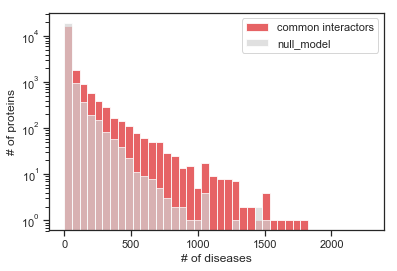

In [148]:
plt.hist(ci_n_diseases, 40, range=(0, 2279), alpha=0.8, label="common interactors")
plt.hist(null_n_diseases, 40, range=(0, 2279), alpha=0.7, color='#D3D3D3', label="null_model")
plt.yscale('log')
plt.legend()
plt.xlabel('# of diseases')
plt.ylabel('# of proteins')

Text(0,0.5,'# of proteins')

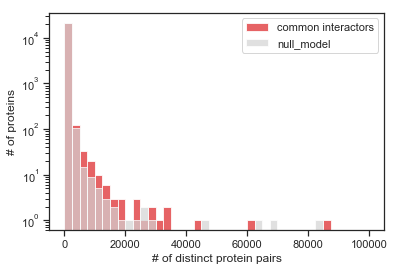

In [241]:
plt.hist(ci_n_pairs, 40, range=(0, 100000), alpha=0.8, label="common interactors")
plt.hist(null_n_pairs, 40, range=(0, 100000), alpha=0.7, color='#D3D3D3', label="null_model")
plt.yscale('log')
plt.legend()
plt.xlabel('# of distinct protein pairs')
plt.ylabel('# of proteins')

## Normalize by Degree
Question: How does degree influence the number of diseases?

In [200]:
ci_n_pairs = np.array(map(len, ci_pairs))
null_n_pairs = np.array(map(len, null_pairs))

In [215]:
degree = [ppi_networkx.degree(node) for node in range(n)]
np.bincount(degree)


array([   0, 4183, 1579, ...,    0,    0,    1])

In [218]:
pairs = comb(degree, 2)
pairs

/Users/sabrieyuboglu/Documents/School/SNAP Research/disease-protein-prediction/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  """Entry point for launching an IPython kernel.


array([  66., 5460.,   55., ...,  120.,    0.,    0.])

In [238]:
ci_n_frac_disease = ci_n_diseases / pairs
null_n_frac_disease = null_n_diseases / pairs

/Users/sabrieyuboglu/Documents/School/SNAP Research/disease-protein-prediction/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.
/Users/sabrieyuboglu/Documents/School/SNAP Research/disease-protein-prediction/env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


Text(0,0.5,'# of proteins')

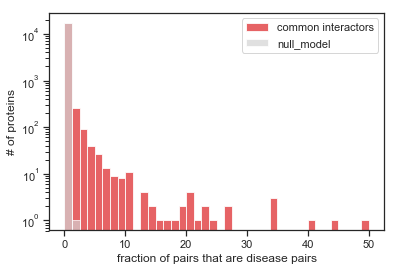

In [239]:
plt.hist(ci_n_frac_disease, 40, range=(0, 50), alpha=0.8, label="common interactors")
plt.hist(null_n_frac_disease, 40, range=(0, 50), alpha=0.7, color='#D3D3D3', label="null_model")
plt.yscale('log')
plt.legend()
plt.xlabel('fraction of pairs that are disease pairs')
plt.ylabel('# of proteins')

In [223]:
ci_topten = [node_to_protein[node] for node in np.argsort(-1 * ci_n_frac_disease)][:10]
ci_topten

[15502, 6523, 30941, 57502, 646, 23213, 4961441, 3590, 42871, 91050]

# Key-Common Interactors
Question: Are there some common interactors that bridge many distinct disease protein pairs? In other 

Text(0,0.5,'# of proteins')

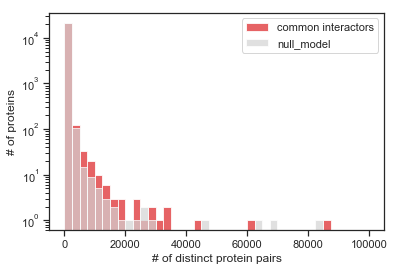

In [242]:
plt.hist(ci_n_pairs, 40, range=(0, 100000), alpha=0.8, label="common interactors")
plt.hist(null_n_pairs, 40, range=(0, 100000), alpha=0.7, color='#D3D3D3', label="null_model")
plt.yscale('log')
plt.legend()
plt.xlabel('# of distinct protein pairs')
plt.ylabel('# of proteins')

In [253]:
pairs, diseases  = compute_common_interactors(diseases_dict, ppi_network_adj, null=False)
n_pairs = np.array(map(len, pairs))

KeyboardInterrupt: 

In [249]:
n_pairs = np.array(map(len, pairs))

Text(0,0.5,'# of proteins')

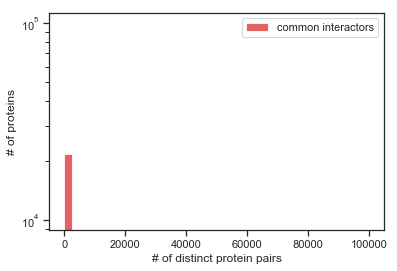

In [252]:
plt.hist(n_pairs, 40, range=(0, 100000), alpha=0.8, label="common interactors")
plt.yscale('log')
plt.legend()
plt.xlabel('# of distinct protein pairs')
plt.ylabel('# of proteins')

In [254]:
null_pairs = []
null_diseases = []
for i in range(20): 
    pairs, diseases  = compute_common_interactors(diseases_dict, ppi_network_adj, null=True)
    null_pairs.append(pairs)
    null_diseases.append(diseases)

# Null Model
Compute a robust null model.

In [256]:
null_n_pairs = [np.array(map(len, pairs)) for pairs in null_pairs]

In [ ]:
with open("../../experiments/disgenet/bio-pathways/ci/null_pairs.pkl",'wb') as f:
    pickle.dump(null_pairs, f)

In [262]:
np.stack(null_n_pairs, axis=1).shape

(21557, 20)

In [263]:
mean_null_n_pairs = np.mean(np.stack(null_n_pairs, axis=1), axis=1)

Text(0,0.5,'# of proteins')

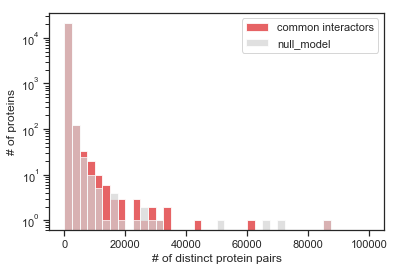

In [264]:
plt.hist(ci_n_pairs, 40, range=(0, 100000), alpha=0.8, label="common interactors")
plt.hist(mean_null_n_pairs, 40, range=(0, 100000), alpha=0.7, color='#D3D3D3', label="null_model")
plt.yscale('log')
plt.legend()
plt.xlabel('# of distinct protein pairs')
plt.ylabel('# of proteins')

## Gene Attributes
Question: what are the characteristics of the common interactors?

In [157]:
parser = GOParser("../../data/go/go-basic.obo", "../../data/go/gene2go")

True
../../data/go/go-basic.obo: fmt(1.2) rel(2018-12-10) 47,372 GO Terms
  20,376 items READ: ../../data/go/gene2go


In [208]:
parser.get_annotations(ci_topten)

{646: {'intracellular part'},
 3590: {'signaling receptor activity'},
 6523: {'establishment of localization', 'system process'},
 15502: set(),
 23213: {'intracellular organelle',
  'intracellular part',
  'membrane-bounded organelle'},
 30941: set(),
 42871: set(),
 57502: {'cellular component organization'},
 91050: set(),
 4961441: set()}

In [163]:
parser.get_annotations(null_topten)

{351: {'regulation of biological process'},
 1994: {'regulation of biological process',
  'regulation of biological quality'},
 2885: {'guanyl-nucleotide exchange factor activity', 'protein binding'},
 4343: {'regulation of biological process', 'signal transduction'},
 4914: {'regulation of biological process',
  'regulation of molecular function'},
 7157: {'macromolecule localization'},
 7316: {'regulation of biological process',
  'regulation of molecular function'},
 7514: {'cellular localization', 'macromolecule localization'},
 8452: {'cellular component organization'},
 10482: {'intracellular part'}}

In [228]:
node = protein_to_node[57502]
ppi_networkx.degree(node)

2